In [31]:
!pip install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight

  Cloning git://github.com/alok-ai-lab/DeepInsight.git to /tmp/pip-install-iy51utov/deepinsight_a74ba42dd6c14d57a2f2c93eec1118a2
  Running command git clone -q git://github.com/alok-ai-lab/DeepInsight.git /tmp/pip-install-iy51utov/deepinsight_a74ba42dd6c14d57a2f2c93eec1118a2
  Created wheel for DeepInsight: filename=DeepInsight-0.1.0-py3-none-any.whl size=17216 sha256=692ef82dc8227af688c7bae8aa288898aa7c0cd7cf276f2e0c8e00346864d4f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-k2_x1ar7/wheels/e4/bc/9d/c483e2a4902573f36c6a2a2e90e247662dada37685d34c1a58
Successfully built DeepInsight


## Load packages

In [61]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## Load the SDN traffic dataset

In [35]:
df = pd.read_csv('/content/drive/MyDrive/SDN/sdn_traffic_dataset.csv')
df.shape

(104345, 23)

In [77]:
df.sample(6)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
623,11395,1,10.0.0.1,10.0.0.8,31769,33865754,70,715000000,7.071500e+10,3,1943,13463,14351558,448,0,UDP,3,216530233,4127,3752,0.0,3752.0,0
666,11275,1,10.0.0.2,10.0.0.8,22746,24247236,50,733000000,5.073300e+10,2,1306,13474,14363284,449,0,UDP,3,96434872,3572,3838,0.0,3838.0,0
796,11455,1,10.0.0.1,10.0.0.8,58837,62720242,130,719000000,1.310000e+11,3,1943,13533,14426178,451,0,UDP,2,3413,3665,0,0.0,0.0,0
740,11335,1,10.0.0.2,10.0.0.8,49807,53094262,110,739000000,1.110000e+11,3,1790,13525,14417650,450,0,UDP,3,3413,3623,0,0.0,0.0,0
360,11515,1,10.0.0.2,10.0.0.8,130706,139332596,290,754000000,2.910000e+11,3,1943,13307,14185262,443,0,UDP,3,231187421,4169,7676,0.0,7676.0,0
567,11395,1,10.0.0.1,10.0.0.8,31769,33865754,70,715000000,7.071500e+10,3,1943,13463,14351558,448,0,UDP,1,3795,1242,0,0.0,0.0,0


In [5]:
df.isna().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [6]:
set(df['rx_kbps'])

{0.0,
 1149.0,
 1155.0,
 1282.0,
 1393.0,
 1725.0,
 1796.0,
 2354.0,
 2358.0,
 2452.0,
 2561.0,
 2562.0,
 2564.0,
 2565.0,
 2566.0,
 2567.0,
 2568.0,
 2571.0,
 2575.0,
 2577.0,
 2580.0,
 2581.0,
 2587.0,
 2588.0,
 2591.0,
 2594.0,
 2603.0,
 2607.0,
 2615.0,
 2619.0,
 2676.0,
 3752.0,
 3837.0,
 3838.0,
 3839.0,
 3840.0,
 3917.0,
 4811.0,
 4993.0,
 5232.0,
 5563.0,
 5564.0,
 5880.0,
 6307.0,
 6384.0,
 6400.0,
 6430.0,
 6446.0,
 6451.0,
 6454.0,
 6456.0,
 6457.0,
 6459.0,
 6464.0,
 6466.0,
 6467.0,
 6501.0,
 6502.0,
 6515.0,
 7165.0,
 7555.0,
 7673.0,
 7674.0,
 7676.0,
 7678.0,
 7756.0,
 8969.0,
 9018.0,
 9473.0,
 9721.0,
 9722.0,
 10120.0,
 10240.0,
 10242.0,
 10243.0,
 10271.0,
 10288.0,
 10289.0,
 10303.0,
 11699.0,
 12817.0,
 12818.0,
 12831.0,
 14134.0,
 15931.0,
 16577.0}

In [7]:
df.dropna(inplace=True)
df.isna().sum()

dt             0
switch         0
src            0
dst            0
pktcount       0
bytecount      0
dur            0
dur_nsec       0
tot_dur        0
flows          0
packetins      0
pktperflow     0
byteperflow    0
pktrate        0
Pairflow       0
Protocol       0
port_no        0
tx_bytes       0
rx_bytes       0
tx_kbps        0
rx_kbps        0
tot_kbps       0
label          0
dtype: int64

In [8]:
df.shape

(1000, 23)

In [9]:
df.Protocol.unique()

array(['UDP'], dtype=object)

In [10]:
bin = {'UDP':0, 
       'TCP':2, 
       'ICMP':3
       }
# apply using map
df['Protocol'] = df.Protocol.map(bin)

In [11]:
dataset = df.values
dataset

array([[11425, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [11605, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [11425, 1, '10.0.0.2', ..., 0.0, 0.0, 0],
       ...,
       [9966, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [9966, 1, '10.0.0.1', ..., 0.0, 0.0, 0],
       [9936, 1, '10.0.0.1', ..., 0.0, 0.0, 0]], dtype=object)

## Split into input X and output Y variables

In [12]:
X = dataset[:,4:22].astype(float)
Y = dataset[:,22]

In [13]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

## Define the model

In [17]:
def model():
	# create model
	model = Sequential()
	model.add(Dense(18, input_dim=18, activation='relu'))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

## Define a basic classifier

In [18]:
estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5)

In [20]:
estimator.fit(X, encoded_Y)

In [21]:
estimator.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                342       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 19        
Total params: 361
Trainable params: 361
Non-trainable params: 0
_________________________________________________________________


In [23]:
estimator.score(X, encoded_Y)

0.8399999737739563

## Evaluate the model with cross validation

In [24]:
estimator = KerasClassifier(build_fn=model, epochs=100, batch_size=5)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
180/180 [==============================] - 1s 2ms/step - loss: 156341248.0000 - accuracy: 0.6944
Epoch 2/100
180/180 [==============================] - 0s 2ms/step - loss: 51134444.0000 - accuracy: 0.7433
Epoch 3/100
180/180 [==============================] - 0s 2ms/step - loss: 34362784.0000 - accuracy: 0.7456
Epoch 4/100
180/180 [==============================] - 0s 2ms/step - loss: 44689560.0000 - accuracy: 0.7467
Epoch 5/100
180/180 [==============================] - 0s 2ms/step - loss: 37555240.0000 - accuracy: 0.7156
Epoch 6/100
180/180 [==============================] - 0s 2ms/step - loss: 43078328.0000 - accuracy: 0.7433
Epoch 7/100
180/180 [==============================] - 0s 2ms/step - loss: 38086932.0000 - accuracy: 0.7400
Epoch 8/100
180/180 [==============================] - 0s 2ms/step - loss: 44507508.0000 - accuracy: 0.7456
Epoch 9/100
180/180 [==============================] - 0s 2ms/step - loss: 58907344.0000 - accuracy: 0.7400
Epoch 10/100
180/180 [=====

## Evaluate baseline model with a standardized dataset

In [26]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=model, epochs=100, batch_size=5)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Standardized: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/100
180/180 [==============================] - 1s 2ms/step - loss: 0.4836 - accuracy: 0.8189
Epoch 2/100
180/180 [==============================] - 0s 2ms/step - loss: 0.1609 - accuracy: 0.9856
Epoch 3/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 1.0000
Epoch 4/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0282 - accuracy: 1.0000
Epoch 5/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 6/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0094 - accuracy: 1.0000
Epoch 7/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 8/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 9/100
180/180 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 10/100
180/180 [==============================] - 0s 2ms/step - loss: 0.0026 - accura

### Using **DeepInsight** to transform a our data to an image for a **Convolutional Neural Network architecture**

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=23, stratify=Y)
X_train.shape

(800, 18)

In [67]:
ln = LogScaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)

In [39]:
it = ImageTransformer(feature_extractor='tsne', 
                      pixels=50, random_state=1701, 
                      n_jobs=-1)

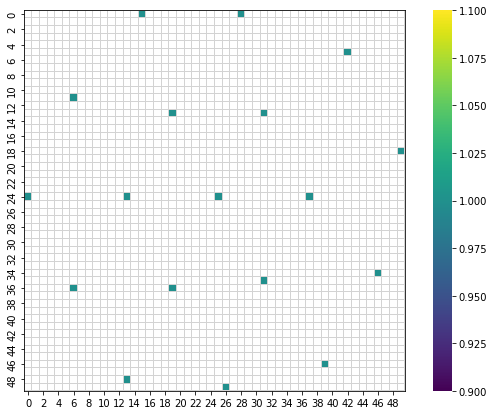

In [41]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 7))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
for _, spine in ax.spines.items():
    spine.set_visible(True)

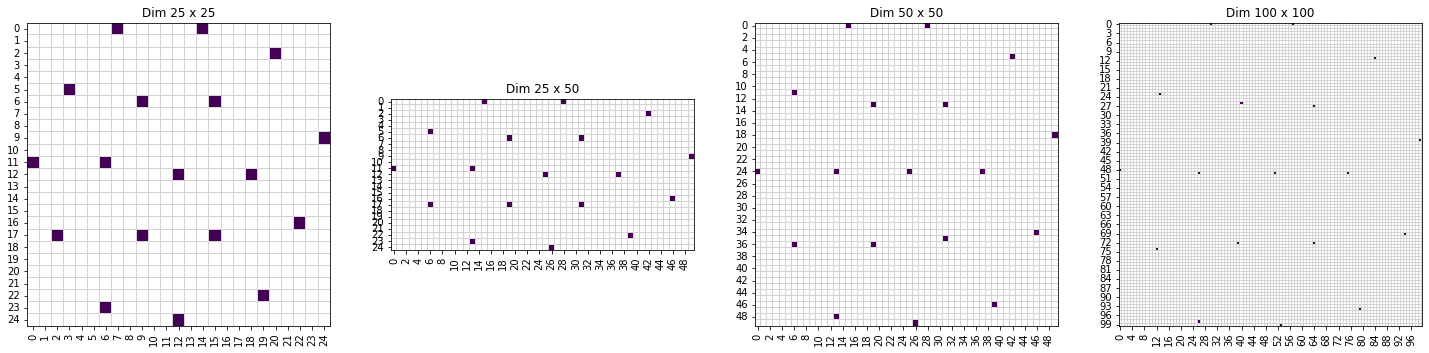

In [42]:
px_sizes = [25, (25, 50), 50, 100]

fig, ax = plt.subplots(1, len(px_sizes), figsize=(25, 7))
for ix, px in enumerate(px_sizes):
    it.pixels = px
    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan
    cax = sns.heatmap(fdm, cmap="viridis", linewidth=0.01, 
                      linecolor="lightgrey", square=True, 
                      ax=ax[ix], cbar=False)
    cax.set_title('Dim {} x {}'.format(*it.pixels))
    for _, spine in cax.spines.items():
        spine.set_visible(True)

it.pixels = 50

In [47]:
mat_train = it.transform(X_train_norm)
mat_test = it.transform(X_test_norm)

In [48]:
mat_train = it.fit_transform(X_train_norm)
mat_test = it.fit_transform(X_test_norm)

In [74]:
mat_train = np.asarray(mat_train).astype('float32')
mat_test = np.asarray(mat_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [51]:
mat_train.shape

(800, 50, 50, 3)

## Train a CNN Model

In [56]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(50, (3, 3), activation='relu', input_shape=(50, 50, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [57]:
cnn_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 50)        1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        28864     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
Total params: 67,192
Trainable params: 67,192
Non-trainable params: 0
_________________________________________________________________


In [58]:
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(10))

In [60]:
cnn_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 50)        1400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 50)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 64)        28864     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 5184)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 64)              

In [76]:
cnn_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = cnn_model.fit(mat_train, y_train, epochs=30, validation_data=(mat_test, y_test))

Epoch 1/30
25/25 [==============================] - 5s 191ms/step - loss: 0.2064 - accuracy: 0.9225 - val_loss: 0.1539 - val_accuracy: 0.9350
Epoch 2/30
25/25 [==============================] - 5s 182ms/step - loss: 0.1598 - accuracy: 0.9362 - val_loss: 0.1205 - val_accuracy: 0.9700
Epoch 3/30
25/25 [==============================] - 5s 181ms/step - loss: 0.1438 - accuracy: 0.9413 - val_loss: 0.0888 - val_accuracy: 0.9800
Epoch 4/30
25/25 [==============================] - 5s 181ms/step - loss: 0.1050 - accuracy: 0.9625 - val_loss: 0.1201 - val_accuracy: 0.9450
Epoch 5/30
25/25 [==============================] - 5s 181ms/step - loss: 0.1301 - accuracy: 0.9588 - val_loss: 0.0650 - val_accuracy: 0.9650
Epoch 6/30
25/25 [==============================] - 4s 178ms/step - loss: 0.0987 - accuracy: 0.9688 - val_loss: 0.1111 - val_accuracy: 0.9600
Epoch 7/30
25/25 [==============================] - 5s 182ms/step - loss: 0.0941 - accuracy: 0.9650 - val_loss: 0.0519 - val_accuracy: 0.9800
Epoch 